# Extra installs

In [1]:
#!pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl
!pip install torchsummary
!pip install sparse
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00


# Imports

In [2]:
import os
import time
import gc
import torch.nn as nn
from tqdm import tqdm
import pyarrow.parquet as pq
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import sparse
import torchvision
from torchvision.datasets.folder import DatasetFolder
# imports the torch_xla package
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from tqdm import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange


# Dataset

In [3]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/datasets/ML4SCI_GSOC23/Task2

Task2_large.zip  Task2.zip


In [5]:
!rsync -P /content/drive/MyDrive/datasets/ML4SCI_GSOC23/Task2/Task2_large.zip .

Task2_large.zip
    511,755,972 100%   89.91MB/s    0:00:05 (xfr#1, to-chk=0/1)


In [6]:
!unzip -q Task2_large.zip

In [7]:
!ls data/Task2

Gluon  Quark


In [8]:
np_images_filepath = os.path.join("data", "Task2")
class_to_label = {0 : "Gluon",
                  1 : "Quark"}

model_save_folder = os.path.join(data_filepath, "models", "Task2")

os.makedirs(model_save_folder, exist_ok=True)
print(os.listdir(np_images_filepath))

['Quark', 'Gluon']


# EDA

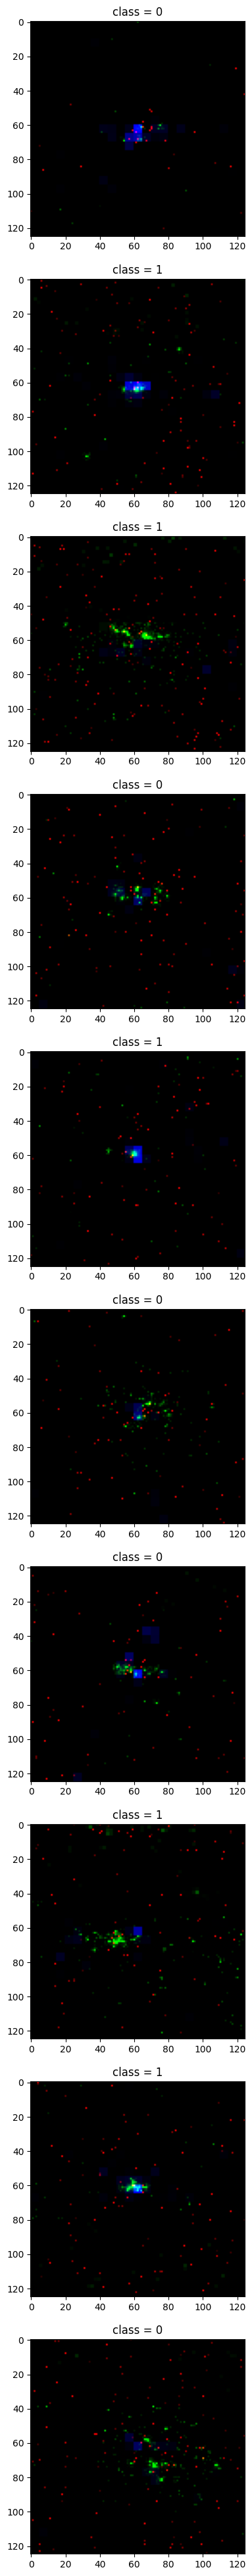

In [9]:
def get_n_random_from_class(_class : int, n : int) -> list:
  class_filepath = os.path.join(np_images_filepath, class_to_label[_class])
  files = [os.path.join(class_filepath, f) for f in os.listdir(class_filepath)]
  idxes = np.random.permutation(np.arange(0, len(files)))[:n]

  return [(_class, files[i]) for i in idxes]

gluons = get_n_random_from_class(0, 5)
quarks = get_n_random_from_class(1, 5)

to_viz = gluons + quarks
np.random.shuffle(to_viz)

scale = 5
n = len(to_viz)
plt.figure(figsize=(scale, n* scale))
for i, datapoint in enumerate(to_viz):
  cls = datapoint[0]
  #print(datapoint[1])
  img = sparse.load_npz(datapoint[1]).todense()
  plt.subplot(n, 1, i + 1)
  plt.imshow(img)
  plt.title(f"class = {cls}")

plt.show()

# Pytorch Dataset Creation

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [11]:
from torch.utils.data import DataLoader

"""
# For small dataset 
mean = np.array([0.00782386,0.00482207,0.00304506])
std = np.array([0.63704916,0.18686025,0.04598732])
"""

# Large dataset
mean = np.array([0.00793777, 0.00491434, 0.00303773])
std = np.array([1.89825445, 0.18734633, 0.04594031])

def load_npy(path : str) -> torch.Tensor:
    # load from sparse representation
    img = sparse.load_npz(path).todense()
    
    # normalize the image
    img = (img - mean) / std

    # convert to pytorch representation
    img = img.transpose(2, 0, 1)
    
    return torch.from_numpy( img )

train_ds = DatasetFolder(np_images_filepath, extensions=[".npz"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [12]:
next(iter(train_dl))[0].shape

torch.Size([32, 3, 125, 125])

# Test Run

In [13]:
def training_epoch(model, criterion, optimizer, scheduler, dataloader, dataset_size, saveTo, num_epochs=25):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()

        i = 0
        # Iterate over data.
        for inputs, labels in tqdm(dataloader):
            i += 1
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                pred_labels = (outputs >= 0.5).reshape(-1)

                #print(outputs.shape)
                loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)
            if i % 25 == 0:
              gc.collect()

        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model
    return returnDict


In [14]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    #plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    #plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    #plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    #plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()

    plt.show()

In [15]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, _summary=True):
  if _summary:
    print(summary(model_ft, input_size=(3, 125, 125), device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)

  dats = training_epoch(model_ft, F.binary_cross_entropy, optim, lr_sched, train_dl, 
                 len(train_ds) , 
                 os.path.join(model_save_folder, "Simple.pt"), 
                 num_epochs=epochs)
  
  if plot:
    plotResults(dats)
  return dats


# Basic CNN

In [ ]:
import torch.nn as nn

class startingModel(nn.Module):
    def __init__(self):
        super(startingModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
      
        self.conv3 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv6_bn = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(4096, 64, bias=False)
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv2 = self.pool1(conv2)

        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv4 = self.pool2(conv4)

        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv6 = self.pool3(conv6)

        flat1 = torch.flatten(conv6.permute(0, 2, 3, 1), 1)
        fc1 = F.relu(self.fc1(flat1))
        logits = self.fc2(fc1)
        return self.sigmoid(logits)


doExperiment(startingModel())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 121, 121]           4,800
       BatchNorm2d-2         [-1, 64, 121, 121]             128
            Conv2d-3         [-1, 64, 117, 117]         102,400
       BatchNorm2d-4         [-1, 64, 117, 117]             128
         MaxPool2d-5           [-1, 64, 58, 58]               0
            Conv2d-6           [-1, 64, 54, 54]         102,400
       BatchNorm2d-7           [-1, 64, 54, 54]             128
            Conv2d-8           [-1, 64, 50, 50]         102,400
       BatchNorm2d-9           [-1, 64, 50, 50]             128
        MaxPool2d-10           [-1, 64, 25, 25]               0
           Conv2d-11           [-1, 64, 21, 21]         102,400
      BatchNorm2d-12           [-1, 64, 21, 21]             128
           Conv2d-13           [-1, 64, 17, 17]         102,400
      BatchNorm2d-14           [-1, 64,

100%|██████████| 4354/4354 [11:26<00:00,  6.34it/s]


Loss: 0.5710 Acc: 0.7121 AUC ROC : 0.7753 Time taken : 686.65

Epoch 1/9
----------


100%|██████████| 4354/4354 [11:15<00:00,  6.44it/s]


Loss: 0.5589 Acc: 0.7225 AUC ROC : 0.7869 Time taken : 675.8

Epoch 2/9
----------


100%|██████████| 4354/4354 [11:15<00:00,  6.45it/s]


Loss: 0.5554 Acc: 0.7239 AUC ROC : 0.7901 Time taken : 675.4

Epoch 3/9
----------


 39%|███▊      | 1687/4354 [04:17<06:34,  6.76it/s]

# Resnet

## Architecture

In [ ]:
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return 

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.logits = nn.Linear(512 * block.expansion, 1)
        self.activ_head = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.logits(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self.activ_head(self._forward_impl(x))

## Experiments

In [ ]:
doExperiment(ResNet(BasicBlock, [2, 2, 2, 2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

100%|██████████| 4354/4354 [08:48<00:00,  8.23it/s]


Loss: 0.5805 Acc: 0.7077 AUC ROC : 0.7682 Time taken : 528.8

Epoch 1/9
----------


100%|██████████| 4354/4354 [08:33<00:00,  8.48it/s]


Loss: 0.5616 Acc: 0.7200 AUC ROC : 0.7845 Time taken : 514.01

Epoch 2/9
----------


100%|██████████| 4354/4354 [08:33<00:00,  8.47it/s]


Loss: 0.5561 Acc: 0.7242 AUC ROC : 0.7898 Time taken : 514.33

Epoch 3/9
----------


100%|██████████| 4354/4354 [08:33<00:00,  8.48it/s]


Loss: 0.5515 Acc: 0.7284 AUC ROC : 0.7938 Time taken : 513.86

Epoch 4/9
----------


100%|██████████| 4354/4354 [08:32<00:00,  8.50it/s]


Loss: 0.5480 Acc: 0.7300 AUC ROC : 0.7971 Time taken : 512.47

Epoch 5/9
----------


100%|██████████| 4354/4354 [08:32<00:00,  8.50it/s]


Loss: 0.5448 Acc: 0.7335 AUC ROC : 0.7998 Time taken : 512.37

Epoch 6/9
----------


100%|██████████| 4354/4354 [08:31<00:00,  8.51it/s]


Loss: 0.5423 Acc: 0.7348 AUC ROC : 0.8022 Time taken : 512.13

Epoch 7/9
----------


100%|██████████| 4354/4354 [08:32<00:00,  8.50it/s]


Loss: 0.5391 Acc: 0.7370 AUC ROC : 0.8049 Time taken : 512.53

Epoch 8/9
----------


100%|██████████| 4354/4354 [08:31<00:00,  8.51it/s]


Loss: 0.5362 Acc: 0.7384 AUC ROC : 0.8075 Time taken : 512.01

Epoch 9/9
----------


100%|██████████| 4354/4354 [08:31<00:00,  8.51it/s]


Loss: 0.5328 Acc: 0.7422 AUC ROC : 0.8104 Time taken : 512.07

Training complete in 85m 45s


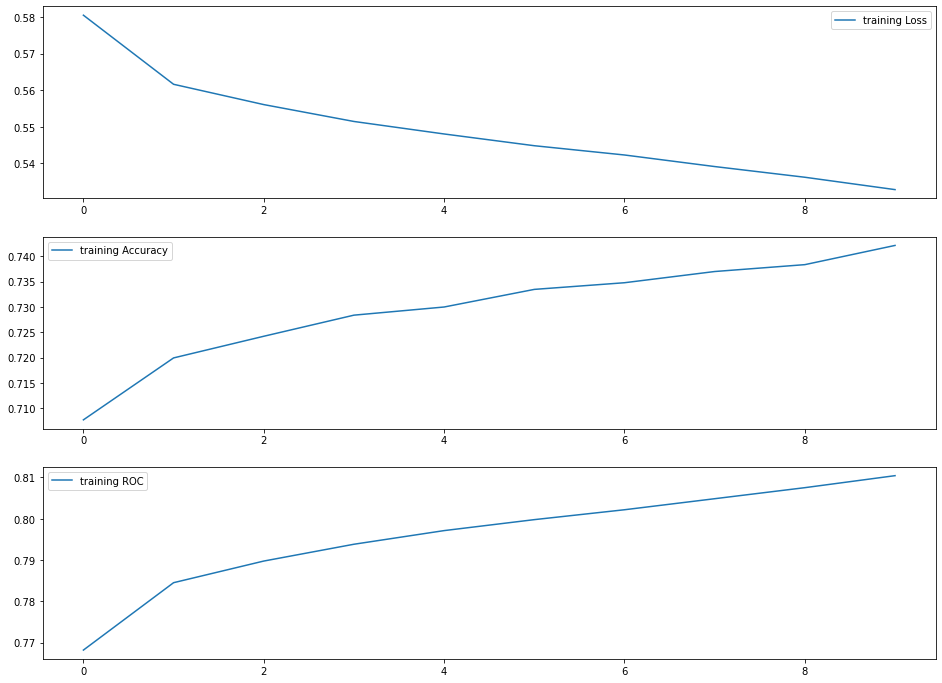

{'trainingLoss': [0.5805357251020384,
  0.5616318690789319,
  0.5560785350607123,
  0.55145961207782,
  0.5480393777651388,
  0.5448257686172663,
  0.5422900571725806,
  0.5391251381534843,
  0.5361986446791882,
  0.5328147655128774],
 'trainingAccuracy': [0.7077441029101403,
  0.7199618106901354,
  0.7242329835039409,
  0.7283964796921885,
  0.7300044506338564,
  0.7334788164185319,
  0.734792471250341,
  0.7370034312951345,
  0.7383601567771668,
  0.7421503739968128],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.7682292630369391,
  0.7845396399129527,
  0.7897735672554717,
  0.7938428021449466,
  0.7971436525244038,
  0.7997973373161696,
  0.8021896958294509,
  0.8048617578771979,
  0.8075342481394552,
  0.8104394284145393],
 'best_model': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): 

In [ ]:
doExperiment(ResNet(BasicBlock, [3, 3, 3, 3]))

# ConvNext

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           1,792
         LayerNorm-2           [-1, 64, 62, 62]             128
            Conv2d-3           [-1, 64, 62, 62]             640
         LayerNorm-4           [-1, 62, 62, 64]             128
            Linear-5          [-1, 62, 62, 256]          16,640
              GELU-6          [-1, 62, 62, 256]               0
            Linear-7           [-1, 62, 62, 64]          16,448
          Identity-8           [-1, 64, 62, 62]               0
             Block-9           [-1, 64, 62, 62]               0
           Conv2d-10           [-1, 64, 62, 62]             640
        LayerNorm-11           [-1, 62, 62, 64]             128
           Linear-12          [-1, 62, 62, 256]          16,640
             GELU-13          [-1, 62, 62, 256]               0
           Linear-14           [-1, 62,

100%|██████████| 4354/4354 [13:22<00:00,  5.43it/s]


Loss: 0.6386 Acc: 0.6261 AUC ROC : 0.6839 Time taken : 802.67

Epoch 1/9
----------


100%|██████████| 4354/4354 [13:08<00:00,  5.52it/s]


Loss: 0.6004 Acc: 0.6841 AUC ROC : 0.7410 Time taken : 789.56

Epoch 2/9
----------


100%|██████████| 4354/4354 [12:57<00:00,  5.60it/s]


Loss: 0.5908 Acc: 0.6935 AUC ROC : 0.7523 Time taken : 778.43

Epoch 3/9
----------


100%|██████████| 4354/4354 [12:51<00:00,  5.65it/s]


Loss: 0.5826 Acc: 0.7022 AUC ROC : 0.7617 Time taken : 771.55

Epoch 4/9
----------


100%|██████████| 4354/4354 [12:45<00:00,  5.68it/s]


Loss: 0.5747 Acc: 0.7088 AUC ROC : 0.7703 Time taken : 766.48

Epoch 5/9
----------


100%|██████████| 4354/4354 [12:42<00:00,  5.71it/s]


Loss: 0.5686 Acc: 0.7138 AUC ROC : 0.7765 Time taken : 763.32

Epoch 6/9
----------


100%|██████████| 4354/4354 [12:36<00:00,  5.76it/s]


Loss: 0.5628 Acc: 0.7191 AUC ROC : 0.7824 Time taken : 757.02

Epoch 7/9
----------


100%|██████████| 4354/4354 [12:36<00:00,  5.76it/s]


Loss: 0.5597 Acc: 0.7215 AUC ROC : 0.7856 Time taken : 756.8

Epoch 8/9
----------


100%|██████████| 4354/4354 [12:36<00:00,  5.75it/s]


Loss: 0.5562 Acc: 0.7248 AUC ROC : 0.7889 Time taken : 757.1

Epoch 9/9
----------


100%|██████████| 4354/4354 [12:37<00:00,  5.75it/s]


Loss: 0.5528 Acc: 0.7268 AUC ROC : 0.7921 Time taken : 757.87

Training complete in 128m 21s


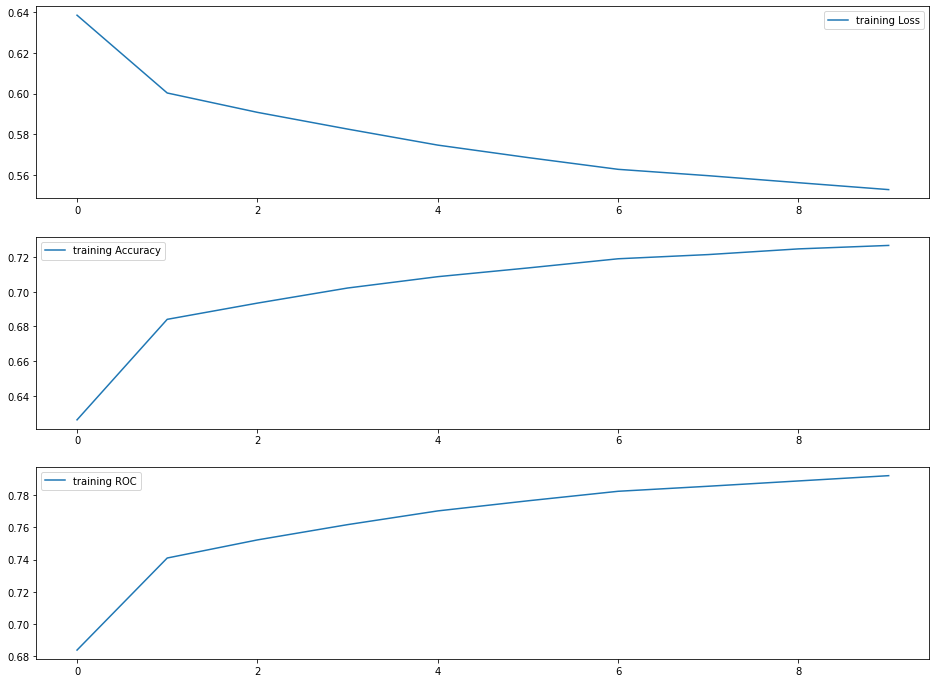

{'trainingLoss': [0.6386335267939575,
  0.6003672644884682,
  0.5908436682676684,
  0.5826167675315245,
  0.5747268379240329,
  0.5685971404695477,
  0.5628115967579922,
  0.5596840803393657,
  0.556231440619714,
  0.5528305794895504],
 'trainingAccuracy': [0.6261108638536746,
  0.6841342081460957,
  0.6934948961279486,
  0.7022095243564528,
  0.7087562631903866,
  0.7137955292665069,
  0.7190932192439665,
  0.7215195325398763,
  0.7248000803985472,
  0.7267956871922243],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.6838913252881451,
  0.7410255352775729,
  0.7522591958071022,
  0.7617429543912102,
  0.7702606284733101,
  0.7765332434439176,
  0.7824389748373628,
  0.7855667711083885,
  0.7888583795778088,
  0.7921355530443032],
 'best_model': ConvNeXt(
   (downsample_layers): ModuleList(
     (0): Sequential(
       (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
       (1): LayerNorm()
     )
     (1): Sequential(
       (0): LayerNorm()
       (1): Conv2d(64, 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
from torchsummary import summary

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=2),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        self.head_activation = nn.Sigmoid()

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activation(x)

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


doExperiment(ConvNeXt(in_chans=3, num_classes=1, depths=[2,2,3,2], dims=[64, 128, 128, 256]))

# Inception

# Vision Transformer



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1           [-1, 5, 5, 1875]               0
            Linear-2            [-1, 5, 5, 256]         480,256
         LayerNorm-3              [-1, 25, 256]             512
            Linear-4             [-1, 25, 1536]         393,216
           Softmax-5            [-1, 8, 25, 25]               0
            Linear-6              [-1, 25, 256]         131,072
         Attention-7              [-1, 25, 256]               0
         LayerNorm-8              [-1, 25, 256]             512
            Linear-9              [-1, 25, 256]          65,792
             GELU-10              [-1, 25, 256]               0
           Linear-11              [-1, 25, 256]          65,792
      FeedForward-12              [-1, 25, 256]               0
        LayerNorm-13              [-1, 25, 256]             512
           Linear-14             [-1, 2

100%|██████████| 4354/4354 [06:29<00:00, 11.18it/s]


Loss: 0.6328 Acc: 0.6485 AUC ROC : 0.6976 Time taken : 389.59

Epoch 1/9
----------


100%|██████████| 4354/4354 [06:21<00:00, 11.41it/s]


Loss: 0.6404 Acc: 0.6347 AUC ROC : 0.6826 Time taken : 382.08

Epoch 2/9
----------


100%|██████████| 4354/4354 [06:19<00:00, 11.46it/s]


Loss: 0.6469 Acc: 0.6248 AUC ROC : 0.6690 Time taken : 380.22

Epoch 3/9
----------


100%|██████████| 4354/4354 [06:25<00:00, 11.29it/s]


Loss: 0.6451 Acc: 0.6275 AUC ROC : 0.6725 Time taken : 386.26

Epoch 4/9
----------


100%|██████████| 4354/4354 [06:29<00:00, 11.19it/s]


Loss: 0.6323 Acc: 0.6464 AUC ROC : 0.6964 Time taken : 389.45

Epoch 5/9
----------


100%|██████████| 4354/4354 [06:26<00:00, 11.27it/s]


Loss: 0.6327 Acc: 0.6464 AUC ROC : 0.6956 Time taken : 386.87

Epoch 6/9
----------


100%|██████████| 4354/4354 [06:22<00:00, 11.39it/s]


Loss: 0.6314 Acc: 0.6477 AUC ROC : 0.6974 Time taken : 382.79

Epoch 7/9
----------


100%|██████████| 4354/4354 [06:17<00:00, 11.55it/s]


Loss: 0.6311 Acc: 0.6485 AUC ROC : 0.6982 Time taken : 377.55

Epoch 8/9
----------


100%|██████████| 4354/4354 [06:22<00:00, 11.39it/s]


Loss: 0.6343 Acc: 0.6435 AUC ROC : 0.6930 Time taken : 382.61

Epoch 9/9
----------


100%|██████████| 4354/4354 [06:23<00:00, 11.34it/s]


Loss: 0.6450 Acc: 0.6275 AUC ROC : 0.6730 Time taken : 384.39

Training complete in 64m 2s


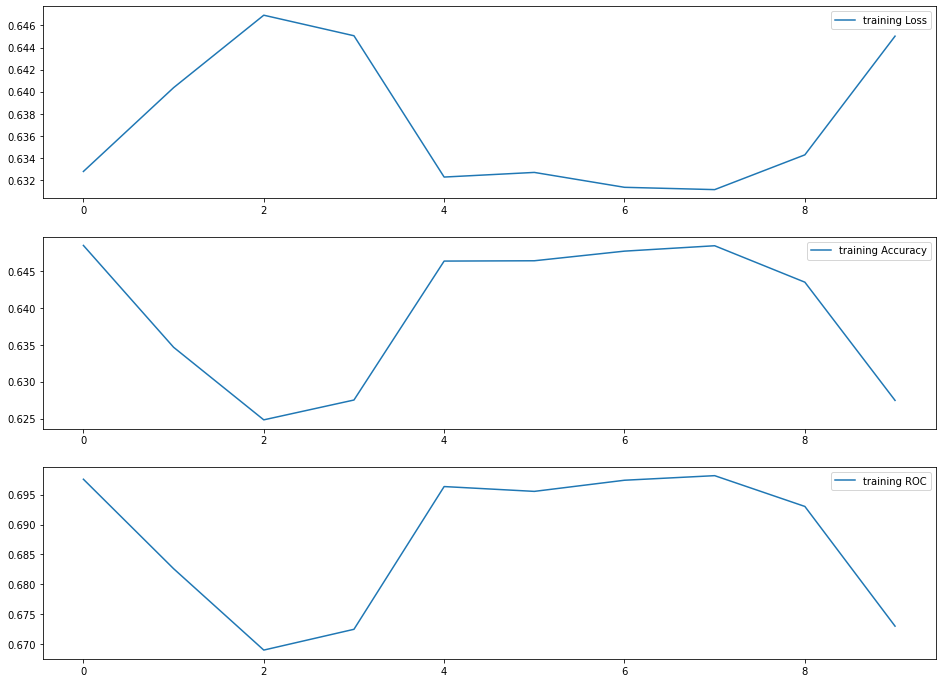

{'trainingLoss': [0.632789227145539,
  0.6403671823874236,
  0.6469213506883571,
  0.6450628852390013,
  0.6322835919090387,
  0.6327029273686021,
  0.631356706777557,
  0.6311475518827913,
  0.6342914471718291,
  0.6450269147399654],
 'trainingAccuracy': [0.6485004235280606,
  0.6346747448063974,
  0.6248187443469772,
  0.6275106599859303,
  0.6463756047837136,
  0.6464186754339368,
  0.6477251518240421,
  0.6484573528778373,
  0.6435114065438675,
  0.6274604108940032],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.6975834733277186,
  0.682626798667153,
  0.6690148134144913,
  0.6724885557889209,
  0.6963592559659539,
  0.6955526623544196,
  0.6974164280324766,
  0.6981813438503712,
  0.6930344901925767,
  0.6730162255152722],
 'best_model': SimpleViT(
   (to_patch_embedding): Sequential(
     (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=25, p2=25)
     (1): Linear(in_features=1875, out_features=256, bias=True)
   )
   (transformer): Transformer(
     (lay

In [ ]:
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t,t)

def posemb_sincos_2d(patches, temperature=10000, dtype=torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'

    omega = torch.arange(dim // 4, device=device) / (dim // 4 - 1)
    omega = 1. / (temperature**omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)


# Classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, 3 * inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3,  dim_head = 64, out_sigmoid=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.ModuleList([])

        if out_sigmoid:
            self.linear_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes),
                nn.Sigmoid()
            )
        else:
            self.linear_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes)
            )


    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.linear_head(x)

doExperiment(SimpleViT(image_size=125, patch_size=25, num_classes=1, dim=256, 
                     depth=4, heads=8, mlp_dim=256, channels=3,out_sigmoid=True))